## Importation des données

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
allData = pd.read_csv("atlas-higgs-challenge-2014-v2.csv")

In [4]:
# On remplace 999 par NaN
allDataModified = allData.replace(-999,np.NaN)
weights = allData["Weight"].to_numpy().ravel()
# On rend la variable de decision Label en int 0 et 1
allDataModified["Label"] = allDataModified["Label"].apply(lambda x: 1 if x == "s" else 0)
# On enlève les columns dont on ne va pas se servir
allDataModified = allDataModified.drop(columns = ["KaggleSet","KaggleWeight","Weight"])
allDataWithoutNan = allDataModified.dropna(axis=1)
allDataModified = allDataModified.fillna(allDataModified.median())
allDataWithoutNan.head()

,EventId,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,...,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_all_pt,Label
0,100000,51.655,97.827,27.980,3.064,41.928,197.760,1.582,1.396,32.638,...,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,113.497,1
1,100001,68.768,103.235,48.146,3.473,2.078,125.157,0.879,1.414,42.014,...,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0
2,100002,162.172,125.953,35.635,3.148,9.336,197.814,3.776,1.414,32.154,...,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,0
3,100003,81.417,80.943,0.414,3.310,0.414,75.968,2.354,-1.285,22.647,...,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-0.000,0
4,100004,16.915,134.805,16.405,3.891,16.405,57.983,1.056,-1.385,28.209,...,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,0.000,0


On découpe en train et test

In [5]:
x = allDataModified.loc[:,allDataModified.columns != 'Label']
x = x.loc[:, x.columns != 'EventId']
y = allDataModified.loc[:,allDataModified.columns == 'Label']
y = y.to_numpy().ravel()
y

array([1, 0, 0, ..., 0, 0, 0])

In [147]:
# Test avec PCA
res = []
for i in range(1,20):
    print(i)
    myPca = PCA(n_components=i)
    myPca.fit(x)
    res.append(sum(myPca.explained_variance_ratio_))

#print(myPca.explained_variance_ratio_) 
#print(sum(myPca.explained_variance_ratio_))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


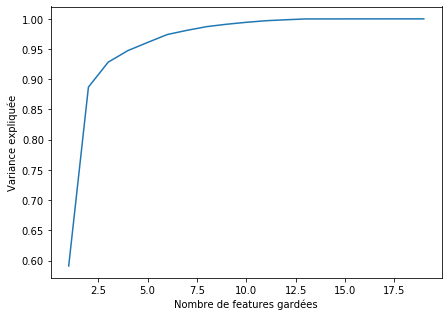

In [148]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(list(range(1,20)),res)
plt.xlabel("Nombre de features gardées")
plt.ylabel("Variance expliquée")
fig.savefig("plots/pcaExplained.jpg")

code de la function AMS

In [92]:
def AMS(y_true,y_pred,weights,br=10):
    confMat = confusion_matrix(y_true,y_pred)
    
    s = 0
    b = 0
    for i in range(len(y_true)):
        # Vrai positif
        if y_pred[i] == 1:
            if y_true[i] == 1:
                s += weights[i]
            else:
                b += weights[i]
    result = np.sqrt(2 * ((s+b+br) * np.log(1 + s / (b + br)) - s ) )
    return result

#amsScorer = make_scorer(AMS, greater_is_better=True)
#AMS([0,0,1,1,1,1,1],
    #[0,1,0,1,0,1,1])

In [93]:
nbSplit = 5
kf = StratifiedKFold(n_splits=nbSplit,shuffle=True,random_state=42)
listIndexFolds = list(kf.split(x,y))
#aa = list(kf.split(x,y))
#print(aa[0][0].shape)
#aa[0][1].shape
#len(aa)
#allDataModified.iloc[aa[0][1]]

In [149]:
def crossValidation(predictor, x, y, listIndexFolds, weights=None):
    
    nbSplit = len(listIndexFolds)
    result = np.zeros((2,nbSplit))
    for foldCount, (indexTrain, indexTest) in enumerate(listIndexFolds):
        print("FoldCount : ",foldCount)
        xTrain = x.iloc[indexTrain,:] 
        xTest = x.iloc[indexTest,:]
        yTrain = y[indexTrain]
        yTest = y[indexTest]
        
        # PCA Stuff
        #myPCA = PCA(n_components=7)
        #myPCA.fit(xTrain)
        #xTrain = myPCA.transform(xTrain)
        #xTest = myPCA.transform(xTest)
        
        predictor.fit(xTrain,yTrain)
        y_pred = predictor.predict(xTest)
        
        # Fonction de cout
        score = accuracy_score(yTest, y_pred)
        result[0,foldCount] = score
        
       
        weightsTest = weights[indexTest]
        amsScore = AMS(yTest, y_pred,weightsTest)
        result[1,foldCount] = amsScore
        
    return result

# Classification

## Baselines

Decision Tree with one node

In [150]:
mySimpleTree = DecisionTreeClassifier(max_depth = 1)
cv_results = crossValidation(mySimpleTree,x,y,listIndexFolds, weights)
print("accuracy : ", np.mean(cv_results[0,:]), " +- ", np.std(cv_results[0,:])) 
print("AMS : ", np.mean(cv_results[1,:]), " +- ", np.std(cv_results[1,:])) 

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.6753181846808614  +-  0.0011572582589546951
AMS :  0.7353346853511811  +-  0.0045488301957355955


Perceptron

In [151]:
myPerceptron = Perceptron()
cv_results = crossValidation(myPerceptron,x,y,listIndexFolds, weights)
print("accuracy : ", np.mean(cv_results[0,:]), " +- ", np.std(cv_results[0,:])) 
print("AMS : ", np.mean(cv_results[1,:]), " +- ", np.std(cv_results[1,:])) 

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.6048910785976203  +-  0.0792366976908214
AMS :  0.47558836005820604  +-  0.11472271335131633


Naive Bayes

In [152]:
myBayes = GaussianNB()
cv_results = crossValidation(myBayes,x,y,listIndexFolds, weights)
print("accuracy : ", np.mean(cv_results[0,:]), " +- ", np.std(cv_results[0,:])) 
print("AMS : ", np.mean(cv_results[1,:]), " +- ", np.std(cv_results[1,:])) 

FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
accuracy :  0.7091359715209687  +-  0.0009307824128041385
AMS :  0.5263344890306334  +-  0.01133812898612802


[Text(167.4, 163.07999999999998, 'X[0] <= 48.993\ngini = 0.45\nsamples = 818238\nvalue = [538678, 279560]'),
 Text(83.7, 54.360000000000014, 'gini = 0.5\nsamples = 426453\nvalue = [208902, 217551]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.266\nsamples = 391785\nvalue = [329776, 62009]')]

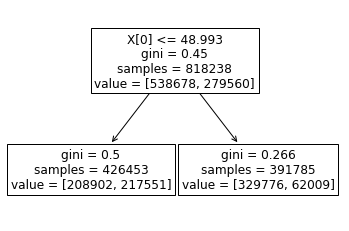

In [126]:
mySimpleTree = DecisionTreeClassifier(max_depth = 1)
mySimpleTree.fit(x,y)
sklearn.tree.plot_tree(mySimpleTree)

## Selection de variables 

## Méthodes d'ensemble avec exploration d'hyper paramètres

Décider des paramètres à explorer pour le random forest

In [133]:
nbArbres = [5,10,50]
profMax = [10,100]

In [144]:
matriceAccMoyenne = np.zeros((len(nbArbres),len(profMax)))
matriceAccVariance = np.zeros((len(nbArbres),len(profMax)))
matriceAmsMoyenne = np.zeros((len(nbArbres),len(profMax)))
matriceAmsVariance = np.zeros((len(nbArbres),len(profMax)))
for countNbArb, nbArb in enumerate(nbArbres):
    for countProf, profondeur in enumerate(profMax):
        print("nb arbre =",nbArb, "\t profondeur=", profondeur)
        myRandomForest = RandomForestClassifier(n_estimators=nbArb, max_depth=profondeur)
        cv_results = crossValidation(myRandomForest,x,y,listIndexFolds,weights)
        matriceAccMoyenne[countNbArb,countProf] = np.mean(cv_results[0,:])
        matriceAccVariance[countNbArb,countProf] = np.std(cv_results[0,:])
        matriceAmsMoyenne[countNbArb,countProf] = np.mean(cv_results[1,:])
        matriceAmsVariance[countNbArb,countProf] = np.std(cv_results[1,:])
        print("moyenne Accuracy :",matriceAccMoyenne[countNbArb,countProf]," +- ",matriceAccVariance[countNbArb,countProf])
        print("moyenne AMS :",matriceAmsMoyenne[countNbArb,countProf]," +- ",matriceAmsVariance[countNbArb,countProf])
print(matriceAccMoyenne)
print(matriceAmsMoyenne)


nb arbre = 5 	 profondeur= 10
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.8073250121926309  +-  0.0019502553102288588
moyenne AMS : 1.089825940385336  +-  0.013797231472900488
nb arbre = 5 	 profondeur= 100
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.7924858035428921  +-  0.0007557545018184981
moyenne AMS : 0.9503512870838005  +-  0.0046284981924863515
nb arbre = 10 	 profondeur= 10
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.8102850247167505  +-  0.0010283200304334063
moyenne AMS : 1.1052390599886275  +-  0.008620029294542704
nb arbre = 10 	 profondeur= 100
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.8050322762376592  +-  0.0007714129208567703
moyenne AMS : 1.0549693989549231  +-  0.007043567907641162
nb arbre = 50 	 profondeur= 10
FoldCount :  0
FoldCount :  1
FoldCount :  2
Fold

In [17]:
np.save("matriceMoyenneRandomForest",matriceMoyenne)
np.save("matriceVarianceRandomForest",matriceVariance)

In [138]:
matriceAmsMoyenne

array([[1.04083554, 0.94523893],
       [1.0493256 , 1.06526217],
       [1.07228581, 1.14807336]])

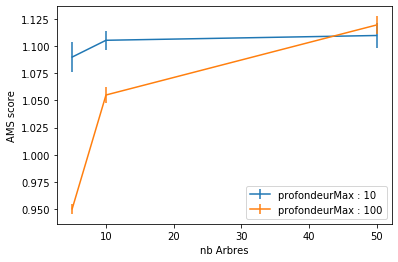

In [145]:
plt.errorbar(nbArbres,matriceAmsMoyenne[:,0],matriceAmsVariance[:,0],label="profondeurMax : "+str(profMax[0]))
plt.errorbar(nbArbres,matriceAmsMoyenne[:,1],matriceAmsVariance[:,1],label="profondeurMax : "+str(profMax[1]))
#plt.errorbar(nbArbres,matriceAmsMoyenne[2,:],matriceAmsVariance[2,:],label="profondeurMax : "+str(profMax[2]))
plt.legend()
plt.xlabel("nb Arbres")
plt.ylabel("AMS score")
plt.savefig("RandomForestArbresFullData.jpg")

AdaBoost

In [163]:
nbEstimators = [1,10,100]

In [130]:
matAccAda = np.zeros((2,len(nbEstimators)))
matAMSAda = np.zeros((2,len(nbEstimators)))
for countNbEstimator, nbEst in enumerate(nbEstimators):
    print("nb estimator =",nbEst)
    myAda = AdaBoostClassifier(n_estimators=nbEst)
    cv_results = crossValidation(myAda,x,y,listIndexFolds,weights)
    matAccAda[0,countNbEstimator] = np.mean(cv_results[0,:])
    matAccAda[1,countNbEstimator] = np.std(cv_results[0,:])
    matAMSAda[0,countNbEstimator] = np.mean(cv_results[1,:])
    matAMSAda[1,countNbEstimator] = np.std(cv_results[1,:])
    print("moyenne Accuracy :",matAccAda[0,countNbEstimator]," +- ",matAccAda[1,countNbEstimator])
    print("moyenne AMS :",matAMSAda[0,countNbEstimator]," +- ",matAMSAda[1,countNbEstimator])
print(matAccAda)
print(matAMSAda)

nb estimator = 1
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.6686648582424661  +-  0.0036119702402740723
moyenne AMS : 0.6719318117005948  +-  0.003932562199921801
nb estimator = 10
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.7329028972485678  +-  0.001578043907248325
moyenne AMS : 0.7919895991765877  +-  0.0039018190970426404
nb estimator = 100
FoldCount :  0
FoldCount :  1
FoldCount :  2
FoldCount :  3
FoldCount :  4
moyenne Accuracy : 0.7448615210197482  +-  0.001296758870763722
moyenne AMS : 0.8804928466412703  +-  0.00454290948581362
[[0.66866486 0.7329029  0.74486152]
 [0.00361197 0.00157804 0.00129676]]
[[0.67193181 0.7919896  0.88049285]
 [0.00393256 0.00390182 0.00454291]]


In [154]:
# AdaBoost sans pré traitement
matAccAda = [[0.6681112348432099, 0.7985427234070376, 0.818378026249813],[0.0007297091458786361, 0.0010682124405013793, 0.0003511076476797158]]
matAMSAda = [[0.7646952397593465,1.056955177522457,1.135298497505358],[0.004521009182686826,0.01022466867878882,0.007072179835980235 ]]

In [131]:
np.save("matAccAdaPCA",matAccAda)
np.save("matAMSAdaPCA",matAMSAda)

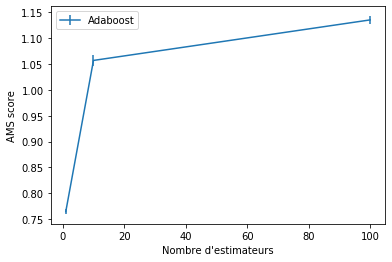

In [164]:
plt.errorbar(nbEstimators,matAMSAda[0],matAMSAda[1],label="Adaboost")
plt.xlabel("Nombre d'estimateurs")
plt.ylabel("AMS score")
plt.legend()
plt.savefig("AdaBoostFullData.jpg")

In [160]:
matAMSAda[0]

[0.7646952397593465, 1.056955177522457, 1.135298497505358]

# TP3 - SUB MANIFOLD

In [ ]:
monTsne = TSNE(n_components=2)
xReduit = monTsne.fit_transform(x)
plt.plot(xReduit)

In [ ]:
plt.scatter(xReduit[:,0], xReduit[:,1])